# Callin Switzer
### 6 June 2019
___

### Use dimensional reduction to visualize the input and output space



1. Run more simulations (could get data from simulations that are alread done), starting from still, and get 8-D final conditions
2. Use t-SNE to visualize

___

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.integrate import odeint
import random
import time
from datetime import datetime
import sys
from multiprocessing import Pool, cpu_count
import simUtils_DLVersion as simUtils # note that this is a custom-written file 
import importlib
import functools
import math

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib.patches import Ellipse

print(sys.version)

3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]


In [145]:
from collections import OrderedDict

globalDict = OrderedDict({"bhead": 0.507,
            "ahead": 0.908,
            "bbutt": 0.1295,
            "abutt": 1.7475, 
            "rho": 1, 
            "rhoA": 0.00118, 
            "muA": 0.000186, 
            "L1": 0.908, 
            "L2": 1.7475,  
            "L3": 0.75,
            "K": 29.3,
            "c":  14075.8,
            "g": 980.0,
            "betaR":  0.0,
            "nstep": 2,
            "nrun" : 10000  # (max) number of  trajectories.
            })


# Calculated variables
globalDict['m1'] = globalDict['rho']*(4/3)*np.pi*(globalDict['bhead']**2)*globalDict['ahead']
globalDict["m2"] = globalDict["rho"]*(4/3)*np.pi*(globalDict["bbutt"]**2)*globalDict["abutt"]
globalDict["echead"] = globalDict["ahead"]/globalDict["bhead"]
globalDict['ecbutt'] = globalDict['abutt']/globalDict['bbutt']
globalDict['I1'] = (1/5)*globalDict['m1']*(globalDict['bhead']**2)*(1 + globalDict['echead']**2)
globalDict['I2'] = (1/5)*globalDict['m2']*(globalDict['bbutt']**2)*(1 + globalDict['ecbutt']**2)
globalDict['S_head'] = np.pi*globalDict['bhead']**2
globalDict['S_butt'] = np.pi*globalDict['bbutt'] **2
t = np.linspace(0, 0.02, num = globalDict["nstep"], endpoint = True)


# ranges for variables
rangeDict = {"Fmin": 0,
             "Fmax": 44300,
            "alphaMin":  0,
             "alphaMax":2*np.pi, 
            "tau0Min": -100000, 
             "tau0Max": 100000}


# ranges for F, alpha, tau
ranges = np.array([[rangeDict["Fmin"], rangeDict["Fmax"]], 
                   [rangeDict["alphaMin"], rangeDict["alphaMax"]], 
                   [rangeDict["tau0Min"], rangeDict["tau0Max"] ]])

# REFREF: Input data for theta and phi are all positive -- the reason my sim didn't work is because I started with theta negative!!!

In [223]:
# generate initial conditions for state 0
# x,xd,y,yd,theta,thetad,phi,phid
state0_ICs = [0.0, 0.0001, 0.0, 0.0001, np.pi/4, 0.0001, -np.pi/4 - np.pi/2, 0.0001]

# vertical bug version
state0_ICs = [0.0, 0.0001, 0.0, 0.0001, np.pi/2, 0.0001, 3*np.pi/2, 0.0001]

# F, alpha, tau
FAlphaTau_list = np.random.uniform(ranges[:, 0], ranges[:, 1], 
                                   size=(globalDict["nrun"], ranges.shape[0]))

In [224]:
# convert dict to list, since @jit works better with lists
globalList = [ v for v in globalDict.values() ]

In [225]:
# plot moth at certain timesteps
# plot final positions
def plotMoth(x,y,theta, phi, F, alpha, tau0, fig, ax):
    # plot moth and force
    thoraxLen = 0.908 * 2# cm
    abLen = 1.747 *2 #cm
    bodyWidth = 1.1

    # plot trajectory
    #fig, ax = plt.subplots( figsize = [10,10])
    ax.set_aspect('equal', 'datalim')
    #ax.plot(x,y, label = 'trajectory x vs y')

    center = np.array([x, y])
    head = center + np.array(pol2cart(thoraxLen, theta))
    abTip = center + np.array(pol2cart(abLen, phi))



    xx, yy = zip(*[center, head])
    xab,yab = zip(*[center, abTip])

    el = Ellipse(midpoint(center, head), width = thoraxLen, height = bodyWidth, facecolor='#907760', alpha=0.8, angle = math.degrees(theta))
    el2 = Ellipse(midpoint(center, abTip), width = abLen, height = bodyWidth, facecolor='#DEC9B0', alpha=0.8, angle = math.degrees(phi))
    
#     torqueArc = Arc([x,y], 1, 1, angle=0.0, theta1= np.degrees(theta), theta2=np.degrees(phi), color = "#B61212")
    
    
    ax.add_artist(el)
    ax.add_artist(el2)
#     ax.add_artist(torqueArc)
    
#     # add torque arrow
#     ax.arrow(x = x + 1, y = forceCenter[1], 
#              dx = forceTip[0] - forceCenter[0],  dy =  forceTip[1] - forceCenter[1], 
#             head_width = 0.2, color = "#B61212")

    ax.plot(xx, yy, 'k', alpha = 0.2)
    #ax.scatter(xx, yy, s= 10, c = 'k', alpha = 0.2)
    ax.plot(xab,yab, 'k', alpha = 0.2)
    #ax.scatter(xab,yab, s = 10, c = 'k', alpha = 0.2)

    # plot force 
    forceAlpha = alpha
    forceCenter = midpoint(center, head)
    forceMagnitude = F / 15000 # scale 
    forceAngle = theta + forceAlpha
    forceTip = np.add(pol2cart(forceMagnitude, forceAngle), forceCenter)
    ax.arrow(x = forceCenter[0], y = forceCenter[1], 
             dx = forceTip[0] - forceCenter[0],  dy =  forceTip[1] - forceCenter[1], 
            head_width = 0.2, color = "#B61212")

    
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    '''
    rho: radius
    phi: angle (in radians)
    '''
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def midpoint(p1, p2):
    return ((p1[0]+p2[0])/2, (p1[1]+p2[1])/2)

def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

In [226]:
x,xd,y,yd,theta,thetad,phi,phid = state0_ICs

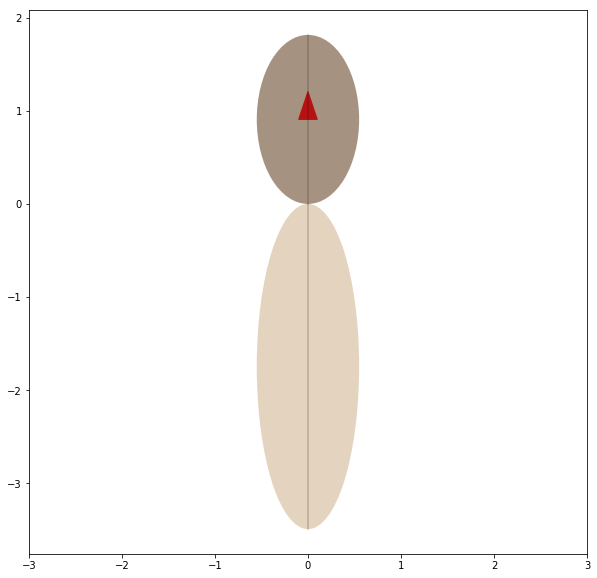

In [227]:
fig, ax = plt.subplots( figsize = [10,10])
plotMoth(x,y,theta, phi, 0, 0, 0, fig, ax)

In [202]:
# simulate many possible final states
# try to run simulations in parallel
p = Pool(cpu_count() - 4)
stt = time.time()
bb = p.map(functools.partial(simUtils.flyBug_dictInput, t=t, 
                              state0_ICs = state0_ICs, 
                              FAlphaTau_list= FAlphaTau_list, 
                              globalList = globalList), range(globalDict["nrun"]))
print(time.time() - stt)
p.close()
p.join()

1.7668788433074951


In [203]:
np.array(bb).shape # shape is nrun, num conditions, timesteps

(10000, 8, 2)

In [204]:
# look at first sim
np.array(bb)[0, :, :]

array([[  0.00000000e+00,   3.13256085e-01],
       [  1.00000000e-04,   2.89687096e+01],
       [  0.00000000e+00,   9.22607593e-01],
       [  1.00000000e-04,   9.22701018e+01],
       [  1.57079633e+00,   1.58289504e+00],
       [  1.00000000e-04,  -8.84548418e-01],
       [ -1.57079633e+00,  -1.64689462e+00],
       [  1.00000000e-04,  -5.29396303e+00]])

In [205]:
InOut = pd.DataFrame(np.hstack([np.array(bb).reshape(globalDict["nrun"], -1, order = "F"), np.array(FAlphaTau_list)]))

In [206]:
colNms = [ii + "_0" for ii in "x,xd,y,yd,theta,thetad,phi,phid".split(",")]
colNms.extend([ii + "_f" for ii in "x,xd,y,yd,theta,thetad,phi,phid".split(",")])
colNms.extend(["F", "alpha", "tau"])
InOut.columns = colNms
InOut.head()

,x_0,xd_0,y_0,yd_0,theta_0,thetad_0,phi_0,phid_0,x_f,xd_f,y_f,yd_f,theta_f,thetad_f,phi_f,phid_f,F,alpha,tau
0,0.0,0.0001,0.0,0.0001,1.570796,0.0001,-1.570796,0.0001,0.313256,28.968710,0.922608,92.270102,1.582895,-0.884548,-1.646895,-5.293963,6359.685597,6.021091,62105.264325
1,0.0,0.0001,0.0,0.0001,1.570796,0.0001,-1.570796,0.0001,-0.364293,-30.485428,-5.460917,-546.466684,1.681923,6.063729,-1.571456,0.462500,29126.660975,3.024326,79146.031020
2,0.0,0.0001,0.0,0.0001,1.570796,0.0001,-1.570796,0.0001,-1.588698,-157.263699,-0.200390,-24.738604,1.789045,23.256690,-1.300760,25.846277,9426.496450,1.548816,-35159.747882
3,0.0,0.0001,0.0,0.0001,1.570796,0.0001,-1.570796,0.0001,-5.377696,-542.227380,1.066058,50.758839,2.292660,75.327162,-0.706700,82.425869,32643.482289,1.269801,-96367.989585
4,0.0,0.0001,0.0,0.0001,1.570796,0.0001,-1.570796,0.0001,-5.050422,-519.453988,1.945149,144.929420,2.225932,68.130829,-0.780180,74.892201,32035.263657,1.113487,-91915.373538


In [211]:
# try pca with final conditions
#Separating out the features
X = InOut.loc[:, [ii + "_f" for ii in "x,xd,y,yd,theta,thetad,phi,phid".split(",")]].values
#X = InOut.loc[:, ["F", "alpha", "tau"]].values

# Standardizing the features
XScaler = StandardScaler().fit(X)
X = XScaler.transform(X)

pca_fit = PCA(n_components=2).fit(X)

pca_out = pca_fit.transform(X)


In [212]:
X[0:1, :]

array([[ 0.10393834,  0.09788186,  0.3903813 ,  0.44688545,  0.02833059,
        -0.01599032, -0.15770962, -0.10907055]])

In [215]:
# compute pca on new data
pca_out2 = pca_fit.transform(XScaler.transform(np.array([[0.0, 0.0001, 0.0, 0.0001, np.pi/2, 0.0001, -np.pi/2, 0.0001]])))

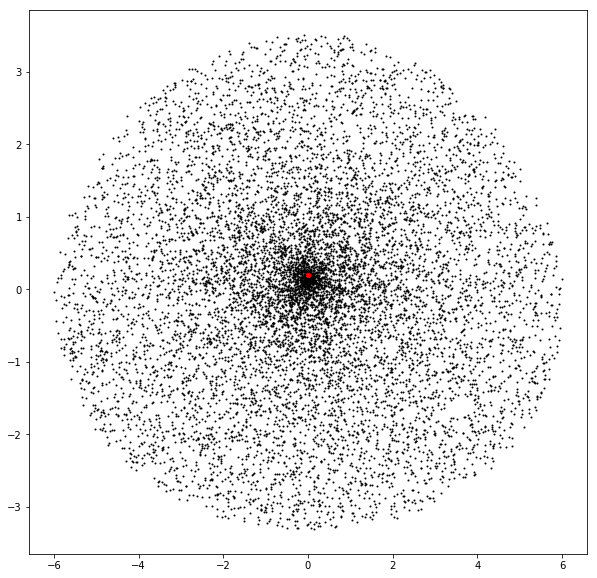

In [216]:
plt.figure(figsize=[10, 10])
plt.scatter(*zip(*pca_out[:,:2]), c="black", s = 1)
plt.scatter(*zip(*pca_out2[:,:2]), c='red', s = 20)
plt.show()

In [219]:
oldNew = InOut.loc[:, [ii + "_f" for ii in "x,xd,y,yd,theta,thetad,phi,phid".split(",")]]
ndf = pd.DataFrame(np.array([[0.0, 0.0, 0.0, 0.0, np.pi/2, 0.0, -np.pi/2, 0.0]]), columns = oldNew.columns)
oldNew = oldNew.append(ndf)
oldNew["colors"] = np.repeat("black", InOut.shape[0]).tolist()  + ["red"]
oldNew.head()


,x_f,xd_f,y_f,yd_f,theta_f,thetad_f,phi_f,phid_f,colors
0,0.313256,28.968710,0.922608,92.270102,1.582895,-0.884548,-1.646895,-5.293963,black
1,-0.364293,-30.485428,-5.460917,-546.466684,1.681923,6.063729,-1.571456,0.462500,black
2,-1.588698,-157.263699,-0.200390,-24.738604,1.789045,23.256690,-1.300760,25.846277,black
3,-5.377696,-542.227380,1.066058,50.758839,2.292660,75.327162,-0.706700,82.425869,black
4,-5.050422,-519.453988,1.945149,144.929420,2.225932,68.130829,-0.780180,74.892201,black


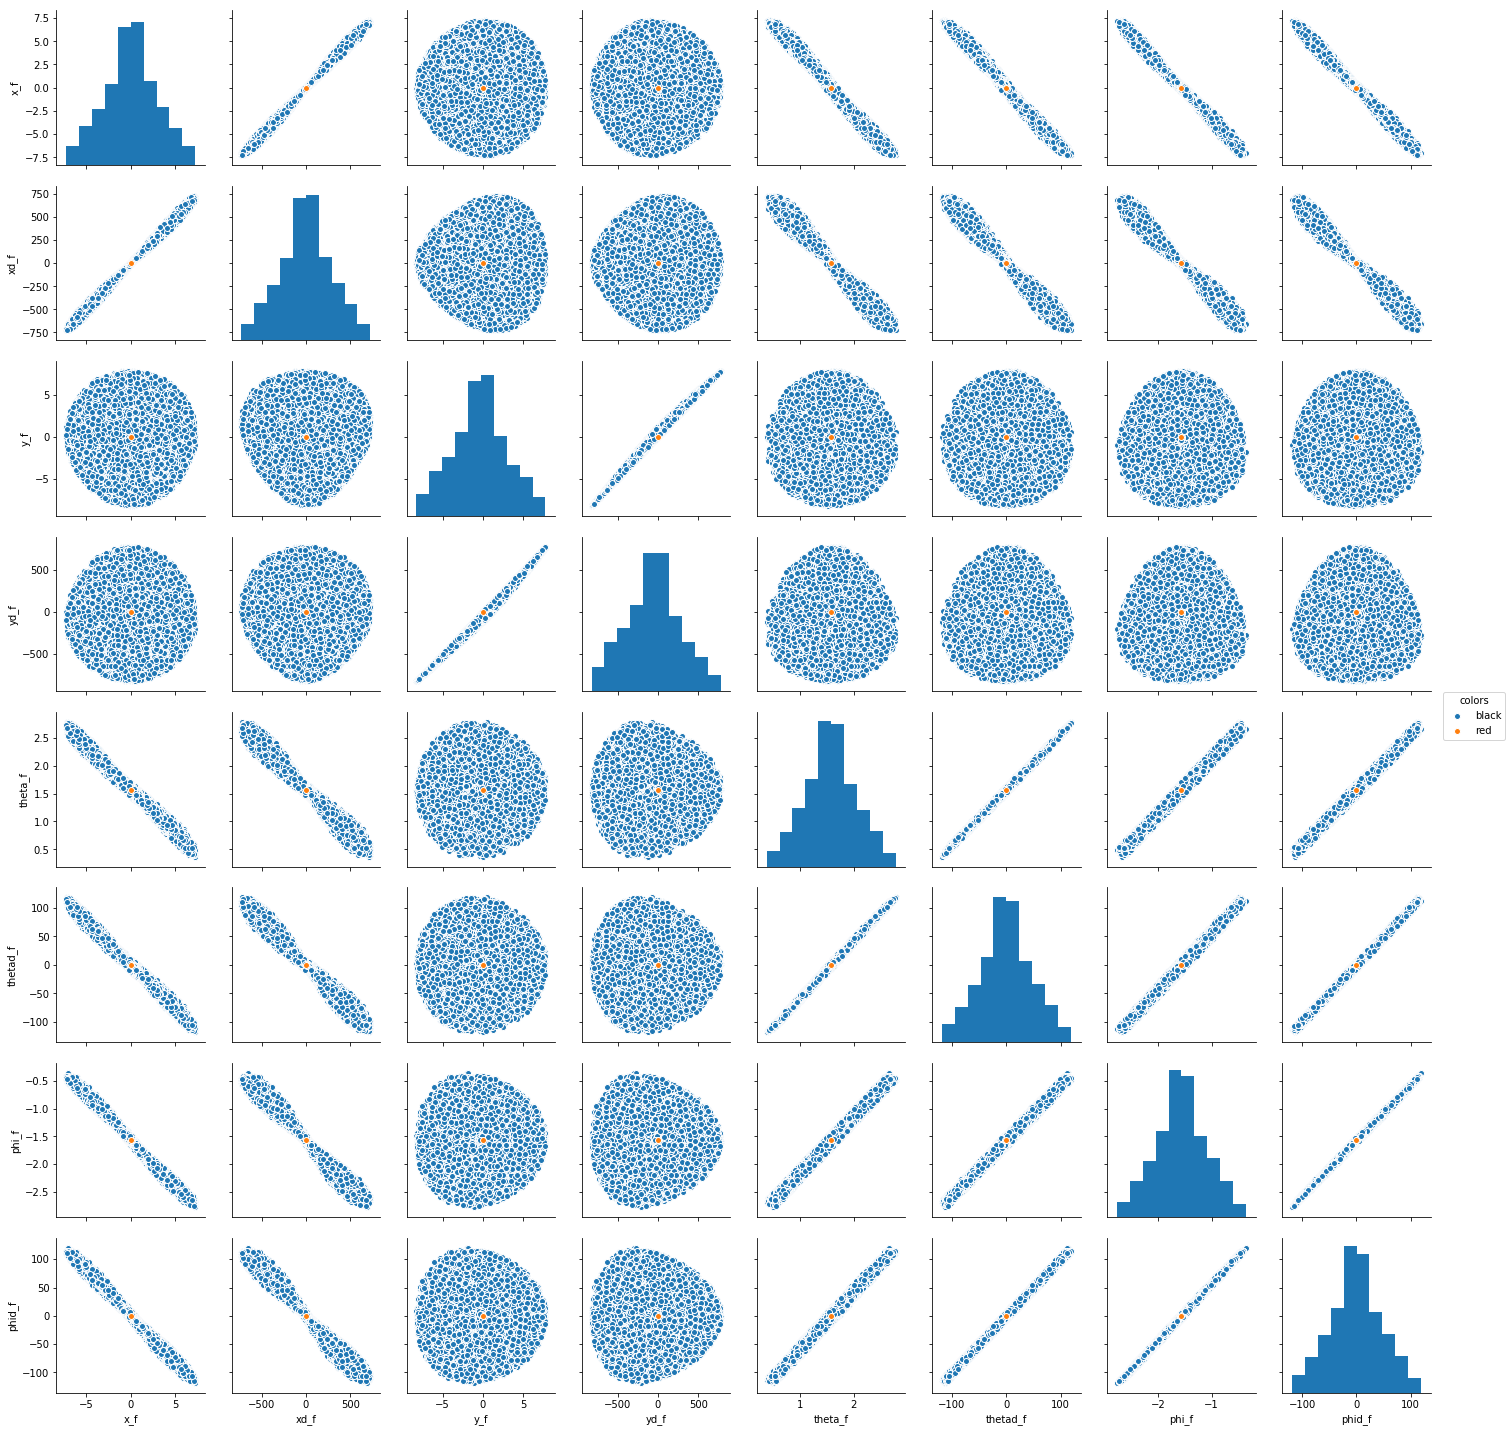

In [220]:
pp = sns.pairplot(oldNew, hue = "colors")

In [221]:

#Separating out the features
X = oldNew.loc[:, [ii + "_f" for ii in "x,xd,y,yd,theta,thetad,phi,phid".split(",")]].values
#X = InOut.loc[:, ["F", "alpha", "tau"]].values

# Standardizing the features
X = StandardScaler().fit_transform(X)

tsne_fit = TSNE(n_components=2)

tsne = tsne_fit.fit_transform(X)



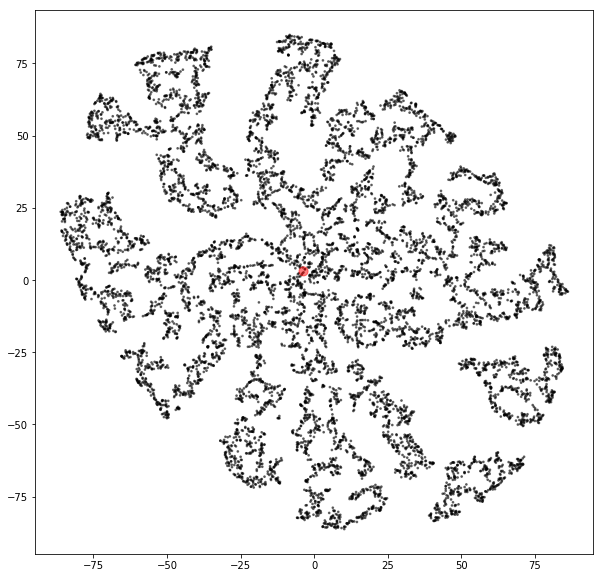

In [222]:
#plt.scatter(*zip(*tsne[:,:2]))
plt.figure(figsize=[10, 10])
plt.scatter(*zip(*tsne[:,:2]), c=oldNew["colors"], s = (oldNew["colors"]=="red")*80+3, alpha = 0.5)
plt.show()

# Make training and test set

In [ ]:
# read in data
trainDF = pd.read_hdf(os.path.join(dataOutput, "concatenatedRandomICs.h5"), key = "data")

In [ ]:
# refref: check for repeats!

In [ ]:
# double check for repeats!
np.sum(trainDF.iloc[:, [16,17,18]].duplicated()) # 0 means no repeats

In [ ]:
print(trainDF.shape)
trainDF.head()

In [ ]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "xf" : "x_99", "yf" : "y_99", "phif" : "phi_99", "thetaf" : "theta_99", 
                        "xd0" : "x_dot_0", "yd0" : "y_dot_0", "phid0" : "phi_dot_0", "thetad0": "theta_dot_0", 
                        "xdf" : "x_dot_99", "ydf": "y_dot_99", "phidf": "phi_dot_99", "thetadf": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [ ]:
# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

In [ ]:
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0",
                   "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau"] ]

In [ ]:
X.head()

In [ ]:
Y.head()

In [ ]:
# test train split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [ ]:
# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xtest_scaled = scalerX.transform(Xtest)
Ytest_scaled = scalerY.transform(Ytest)

In [ ]:
pd.DataFrame(Xtrain_scaled, columns = X.columns).head()

In [ ]:
# save scalers, to be used on test set
scalerfileX = 'scalerX_veloc.pkl'
pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

scalerfileY = 'scalerY_veloc.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

# Keras models

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
K.clear_session()

In [ ]:
# refref: start with small network and then build up
# refref: start with large network and prune

In [ ]:
# create network
def create_network(optimizer = 'rmsprop', 
                    numUnits = [32, 32, 32, 32], 
                    weightRegularization = 0.0, 
                    dropout_rate=0.1):
    
    '''
    Create a feed forward network.  Assumes Xtrain & Ytrain have been created and scaled
    
    Params: 
    optimizer (str): choice of optimizer
    numUnits (list): number of units in each hidden
    weightRegularization (float): between 0 and 1
    dropout_rate (float): between 0 and 1
    
    '''
    K.clear_session()
    inputs = Input(shape=(Xtrain_scaled.shape[1],))    
    
    # add layers
    for ii in np.arange(0, len(numUnits)):
        if ii >= 1: 
            x = Dense(numUnits[ii], activation='tanh', 
                      kernel_regularizer=regularizers.l1(weightRegularization))(x)

        else: 
            x = Dense(numUnits[ii], activation='tanh')(inputs)


        # add dropout
        if dropout_rate > 0: 
            x = Dropout(dropout_rate)(x)
    
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [ ]:
modelParams = {"optimizer": "rmsprop", 
              "dropout_rate" : 0.0, 
               "numUnits": [512, 512, 512, 16],
               "weightRegularization": 0.0
              }


model = create_network(**modelParams)

modelName = ''.join('{}_{}__'.format(key[0:3].capitalize(), val) for  key, val in modelParams.items()).replace("[", "").replace("]", "").replace(", ", "_")[0:-2]
print(modelName)

model.summary()

In [ ]:
#model.get_config()
earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=50, 
                          verbose=1, mode='auto', min_delta = 0.000001)

In [ ]:
# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

In [ ]:
# # fit model without regularization
stt = time.time()
history = model.fit(Xtrain_scaled, Ytrain_scaled, epochs = 1000, verbose = 2, 
                        batch_size=2**13, callbacks = [earlystop], validation_split = 0.3)
winsound.PlaySound("*", winsound.SND_ALIAS)
endd = time.time() - stt
print(endd)

In [ ]:
historyDict["mean_squared_error"].extend(history.history["mean_squared_error"])
historyDict["val_mean_squared_error"].extend(history.history["val_mean_squared_error"])

In [ ]:
model.save(os.path.join(savedModels,  modelName + "_velocity" + '.h5'))

In [ ]:


fig, axs = plt.subplots(1,1,figsize=(10,5))
# summarize history for accuracy
axs.plot(historyDict["mean_squared_error"])
axs.plot(historyDict["val_mean_squared_error"])
axs.set_title('Model MSE = '+ str((historyDict['val_mean_squared_error'][-1])))
axs.set_ylabel('mean_squared_error')
axs.set_xlabel('Epoch')
axs.legend(['train', 'val'], loc='best')
plt.yscale('log') #logarithmic scale for y axis


In [ ]:
# refref: Can I overfit, if I turn off all regularization? With a small dataset

In [ ]:
# refref: visualize poossible state space from certain starting spaces using t-SNE

In [ ]:
history.history['val_loss'][-1]# MSE for final epoch testing
# why are val MSE vs. loss different????  answer : I think loss incorporates regularization. 

In [ ]:
history.history['val_mean_squared_error'][-1] # it is the same when there is no regularization

In [ ]:
history.history['loss'][-1]# MSE for final epoch training

In [ ]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]


In [ ]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history.history['val_mean_squared_error'][-1])) + "\n" +  str(nzwts) + " non-zero weights")
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + ".png"), dpi = 120, bbox_inches='tight')
    
    plt.show()
    
plot_model_history(history, saveFig=True)

In [ ]:
# save model
model.save(os.path.join(savedModels,  modelName + '.h5'))

In [ ]:
# save weights
wts = model.get_weights().copy()

wtsFile = modelName + '_wts.pkl'
pickle.dump(wts, open(os.path.join(dataOutput, wtsFile), 'wb'))

In [ ]:
# read file back in 
wt2 = pickle.load(open(os.path.join(dataOutput, wtsFile), 'rb'))

In [ ]:
# END
os.path.join(dataOutput, wtsFile)

___

## START NEW ITEM: train and trim weights

In [ ]:
# train and trim weights

In [ ]:
modelParams = {"optimizer": "rmsprop", 
              "dropout_rate" : 0.0, 
               "numUnits": [32, 32, 32, 32],
               "weightRegularization": 0
              }


model = create_network(**modelParams)
wts = model.get_weights().copy()

In [ ]:
from  mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


In [ ]:
newcolors.shape

In [ ]:
wts = model.get_weights().copy()

plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array([30, 10])/2, facecolor='w', edgecolor='k', sharex = "none", sharey = "none")
fig.subplots_adjust(hspace = -0.7, wspace=0.1, bottom = -0.1 )
axs = axs.ravel("F")


viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([0.8, 0.8, 0.8, 1])
newcolors[256//2-5:256//2+5, :] = white
newcmp = ListedColormap(newcolors)


for jj, ii in enumerate(np.arange(0, len(wts), 1)):
    
    

    
    if len(wts[ii].shape) < 2: 
        wtsTmp = wts[ii].reshape(1,-1).copy()
    else:
        wtsTmp = wts[ii].copy()
    
    im = axs[jj].matshow(wtsTmp, cmap = newcmp, norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    



    
    if np.mod(ii+1, 2) == 0:
        axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].axes.set_ylim([-1, 1])
        axs[jj].axes.set_xlim([-1, 32])
        
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].tick_params(top = False, labelbottom = True, labeltop = False)
        

    
    if (np.mod(jj, 2) == 0) and (jj != 0):
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])
            
        axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].axes.set_ylim([-1, 32])
        axs[jj].axes.set_xlim([-1, 32])
        #axs[jj].axis('off')
        
        
    if ii == 9:
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].get_xaxis().set_ticks([0, 5])
        axs[jj].axes.set_xlim([-1, 32])
        
    if ii == 0:
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        #axs[jj].get_yaxis().set_ticks([])


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].get_yaxis().set_ticks([0, 5])
        axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


        #axs[jj].axes.set_ylim([-1, 32])

    
    #axs[jj].axis('off')

cbaxes = inset_axes(axs[8], width="5%", height="95%", loc= "center") 
cbar = fig.colorbar(im, cax=cbaxes, orientation="vertical", ticks = [-10, -1, 0, 1, 10])    
    
#fig.colorbar(im, orientation="horizontal", pad=0.2)



plt.savefig(os.path.join(figDir, "RandomWeightMatrices.png"), dpi = 500, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
from keras.models import load_model
model = load_model("D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels\Opt_rmsprop__Dro_0.0__Num_32_32_32_32__Wei_0_pruned_bias.h5")

modelName = ''.join('{}_{}__'.format(key[0:3].capitalize(), val) for  key, val in modelParams.items()).replace("[", "").replace("]", "").replace(", ", "_")[0:-2]
print(modelName)

model.summary()

In [ ]:
wts = model.get_weights().copy()

wtsFile = modelName + '_wts.pkl'
pickle.dump(wts, open(os.path.join(dataOutput, wtsFile), 'wb'))

In [ ]:
# read in data
#wts =  pickle.load(open(os.path.join(dataOutput, wtsFile), 'rb'))

# print sizes of each weight matrix
wtLengths = []
for ii in range(len(wts)):
    print(wts[ii].shape)
    wtLengths.append(np.prod(wts[ii].shape))

print(np.sum(wtLengths), "total weights")

In [ ]:
# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

In [ ]:
numCuts = 0

In [ ]:
# refref: 
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
def prune_percent_updater(x):
    logit = np.exp(x*8) / (np.exp(x*8) + 1)
    return((logit - 0.5)*2*50)


# cuts a smaller portion as the percent gets closer to 100%
cutPercent = prune_percent_updater(np.linspace(0, 1, 25))

while True:   
   
    for numEpocs in range(100):
        
        MSE_tmp = []

        history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
                            verbose = 2, batch_size=2**14, epochs = 1, 
                            callbacks = [earlystop])
        
        # refref: earlystop doesn't do anything here
        
        # save history
        historyDict["mean_squared_error"].append(history.history["mean_squared_error"][0])
        historyDict["val_mean_squared_error"].append(history.history["val_mean_squared_error"][0])
        
        # local MSE
        MSE_tmp.append(history.history["mean_squared_error"][0])

        # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
        # get nonzero weights
        wts = model.get_weights().copy()

        # set weights close to 0 to 0 (but ignore biases)
        for ii in np.arange(0, len(wts), 1):
            qants = np.percentile(np.reshape(wts[ii], -1), q = (50 - cutPercent[numCuts], 50 + cutPercent[numCuts]), )
            wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

        # print nonzero weights
        # calculate number of nonzero weights
        nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
        print(nzwts, "of", np.sum(wtLengths), "weights retained")

        # set new weights and calculate new loss
        model.set_weights(wts)
        
        # check the change in mean squared error, and if it's not changing much, then cut out more data
        # calculate slope of loss, based on previous 5 data points
        if numEpocs > 5:
            inputData = historyDict["mean_squared_error"][-5:]

            m = np.shape(inputData)
            X = np.matrix([np.ones(m), np.arange(0, len(inputData))]).T
            y = np.matrix(np.log(inputData)).T

            # Solve for projection matrix
            intercept, slope = np.array(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)).reshape(-1,)
            print("change in log loss:", slope)
    
            # break if slope has stopped changing or if the overall min has been surpassed
            # in the first training, it will automatically prune after 5 epochs, because the min will be passed
            if (np.abs(slope) < 0.001) or (history.history["mean_squared_error"][0] < np.min(historyDict["mean_squared_error"][:-1])): 
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                break
                       
                    
    ## refref: may want to save weights before each pruning, so I can go back, if I need to
    ## refref: should I be pruning the biases too?
    
    ## keep running tally of min mse, and if we can't get back to the min, then break
    print("Min MSE for this prune ", np.min(MSE_tmp), "______overall Min MSE ", np.min(historyDict["mean_squared_error"]))
    if np.min(MSE_tmp) > np.min(historyDict["mean_squared_error"]):
        print("no more gain by pruning:  STOPPING Pruning")
        break
    
    numCuts += 1
    if numCuts > len(cutPercent):
        break

        
        #cutPercent += 0.2
winsound.PlaySound("*", winsound.SND_ALIAS)

In [ ]:
print(numCuts)
(50 - cutPercent[numCuts]) * 2 # percent of original network size that is used the pruned version

In [ ]:
# numCuts = 0

In [ ]:
def plot_model_history_fromDict(model_history_dictionary, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history_dictionary['mean_squared_error'])+1),
             model_history_dictionary['mean_squared_error'])
    axs.plot(range(1,len(model_history_dictionary['val_mean_squared_error'])+1),
             model_history_dictionary['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history_dictionary['val_mean_squared_error'][-1])) + "\n" +  str(nzwts) + " non-zero weights")
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history_dictionary['val_mean_squared_error'])+1),
                   len(model_history_dictionary['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned_2.png"), dpi = 120, bbox_inches='tight')
        print(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"))
    plt.show()
    
plot_model_history_fromDict(historyDict, saveFig = True)

In [ ]:
wts = model.get_weights().copy()

plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array([30, 10])/2, facecolor='w', edgecolor='k', sharex = "none", sharey = "none")
fig.subplots_adjust(hspace = -0.7, wspace=0.1, bottom = -0.1 )
axs = axs.ravel("F")


viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([0.8, 0.8, 0.8, 1])
newcolors[256//2-5:256//2+5, :] = white
newcmp = ListedColormap(newcolors)

for jj, ii in enumerate(np.arange(0, len(wts), 1)):
    
    

    
    if len(wts[ii].shape) < 2: 
        wtsTmp = wts[ii].reshape(1,-1).copy()
    else:
        wtsTmp = wts[ii].copy()
    
    im = axs[jj].matshow(wtsTmp, cmap = newcmp, norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    



    
    if np.mod(ii+1, 2) == 0:
        axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].axes.set_ylim([-1, 1])
        axs[jj].axes.set_xlim([-1, 32])
        
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].tick_params(top = False, labelbottom = True, labeltop = False)
        

    
    if (np.mod(jj, 2) == 0) and (jj != 0):
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])
            
        axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].axes.set_ylim([-1, 32])
        axs[jj].axes.set_xlim([-1, 32])
        #axs[jj].axis('off')
        
        
    if ii == 9:
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].get_xaxis().set_ticks([0, 5])
        axs[jj].axes.set_xlim([-1, 32])
        
    if ii == 0:
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        #axs[jj].get_yaxis().set_ticks([])


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].get_yaxis().set_ticks([0, 5])
        axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


        #axs[jj].axes.set_ylim([-1, 32])

    
    #axs[jj].axis('off')

cbaxes = inset_axes(axs[8], width="5%", height="95%", loc= "center") 
cbar = fig.colorbar(im, cax=cbaxes, orientation="vertical", ticks = [-10, -1, 0, 1, 10])    
    
#fig.colorbar(im, orientation="horizontal", pad=0.2)



plt.savefig(os.path.join(figDir, "Pruned_WeightMatrices.png"), dpi = 700, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
# how good can I get without trimming


In [ ]:
# plot matrices

wts = model.get_weights().copy()
for ii in np.arange(0, len(wts), 2):
    plt.matshow(wts[ii], cmap = "PRGn", norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    plt.colorbar()
    plt.show()

In [ ]:
# plot biases

for ii in np.arange(1, len(wts), 2):
    plt.matshow(wts[ii].reshape(1, -1), cmap = "PRGn", norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    plt.colorbar()
    plt.show()

In [ ]:
# refref: save weights and model
model.save(os.path.join(savedModels,  modelName + '_pruned_bias.h5'))

# save weights
wts = model.get_weights().copy()

wtsFile = modelName + '_pruned_wts_bias.pkl'
pickle.dump(wts, open(os.path.join(dataOutput, wtsFile), 'wb'))

In [ ]:
plt.close("all")
fig, axs = plt.subplots(1,5, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.2)


axs = axs.ravel()

for jj, ii in enumerate(np.arange(0, len(wts), 2)):
    im = axs[jj].matshow(wts[ii], cmap = "PRGn", norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    
    
plt.colorbar(im,ax=axs[jj], orientation = "vertical")
plt.show()

In [ ]:
plt.close("all")
fig, axs = plt.subplots(5,1, figsize=(30, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.5)


axs = axs.ravel()

for jj, ii in enumerate(np.arange(1, len(wts), 2)):
    im = axs[jj].matshow(wts[ii].reshape(1, -1), cmap = "PRGn", norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    axs[jj].axes.get_yaxis().set_visible(False)

plt.colorbar(im,ax=axs[jj], orientation = "horizontal")
plt.show()


In [ ]:
plt.close("all")
fig, axs = plt.subplots(2,5, figsize=(30, 10), facecolor='w', edgecolor='k', )
fig.subplots_adjust(hspace = 0.1, wspace=0.1)


axs = axs.ravel("F")

for jj, ii in enumerate(np.arange(0, len(wts), 1)):
    
    
    
    if len(wts[ii].shape) < 2: 
        wtsTmp = wts[ii].reshape(1,-1).copy()
    else:
        wtsTmp = wts[ii].copy()
    
    im = axs[jj].matshow(wtsTmp, cmap = "PRGn", norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    if np.mod(ii+1, 2) == 0:
        axs[jj].axes.get_yaxis().set_visible(False)

plt.colorbar(im,ax=axs[jj], orientation = "horizontal")
plt.savefig(os.path.join(figDir, "PrunedWeightMatrices.png"))
plt.show()


In [ ]:
os.path.join(dataOutput, wtsFile)

In [ ]:
# refref: if whole node is basically 0, then remove the node. 

In [ ]:
np.std(wts[2].reshape(-1,))

In [ ]:
model = create_network(**modelParams)

history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
                        verbose = 2, batch_size=2**14, epochs = 1, 
                        callbacks = [earlystop])

In [ ]:
# check to see if model saved: 
K.clear_session()
from keras.models import load_model
model = load_model(os.path.join(savedModels, 'my_model_400Units_newData.h5'))

In [ ]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
len(wts[4])

In [ ]:
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,8, figsize=np.array((20,3)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1), bins = 100)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1], bins = 100)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
len(model.get_weights())

In [ ]:
model.evaluate(Xtest_scaled, Ytest_scaled)

In [ ]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# trim weights
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (5, 95), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

In [ ]:
ValLoss = model.evaluate(Xtrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:

wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts)

# trim weights
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (2, 98), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts)
model.set_weights(wts)


# start training
history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
                    verbose = 2, batch_size=2**14, epochs = 1, 
                    callbacks = [earlystop])

In [ ]:
wts = model.get_weights().copy()

# trim weights
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (2.5, 97.5), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts)
model.set_weights(wts)

model.evaluate(Xtest_scaled, Ytest_scaled)


In [ ]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining.png"), dpi = 120, bbox_inches='tight')
    plt.show()
    
plot_model_history(history)
print(history.history["loss"][-1])

In [ ]:
# load model that was trained for much longer
from keras.models import load_model
model = load_model(os.path.join(savedModels, 'my_model.h5'))

In [ ]:
model.summary()

In [ ]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

ValLoss = model.evaluate(Xtrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
wts = model.get_weights().copy()
nzwts = [np.nonzero(wts[ii].reshape(-1))[0] for ii in range(len(wts))]


In [ ]:
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,8, figsize=np.array((20,5)) , facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    axs[jj].hist(nzwts[jj].reshape(-1), bins = 30)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(nzwts[jj].shape))
    axs[jj+1].hist(nzwts[jj+1], bins = 30)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(nzwts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,8, figsize=np.array((10,10)) , facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1), bins = 30)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1], bins = 30)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
# predict on test set
nnpreds = model.predict(Xtest_scaled[ :])

# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

# show residuals
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
axs = axs.ravel()

# replace lightest colors with white
import matplotlib.colors
cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            axs[jj].set_ylabel("Actual - Predicted")
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
plt.tight_layout()
#fig.savefig(os.path.join(figDir, "SmallModelResids.png"), dpi = 120, bbox_inches='tight')


In [ ]:
# trim distribution of weights -- cut out middle 20%
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (40, 60), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# show new histogram of weights (excluding the 0's)
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array((15, 6)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    
    d1 = wts[jj].reshape(-1)
    axs[jj].hist(d1[d1!=0], bins = 30, facecolor = '#d6bddb' )
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))

    d2 = wts[jj+1]
    axs[jj+1].hist(d2[d2!=0], bins = 30, facecolor = '#d6bddb')
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
# the validation.split is the last X% of the data
int(0.3*Xtrain_scaled.shape[0])
ValLoss = model.evaluate(Xtrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

ValLoss = model.evaluate(Xtrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
# predict on test set
nnpreds = model.predict(Xtest_scaled[ :])

# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

# show residuals
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
axs = axs.ravel()

# replace lightest colors with white
import matplotlib.colors
cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            axs[jj].set_ylabel("Actual - Predicted")
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
plt.tight_layout()



In [ ]:
# create dict of hyperparameters


# regularization, num layers, num nodes, learning rate, optimizer, activation function, batch size

from scipy.stats import randint
from scipy.stats import uniform

# Create hyperparameter space
NumHiddenLayers = randint(low = 2, high = 20)#[4, 2, 8]
numUnits  = [2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10]
epochs = [200]
batches1 = [2**12, 2**10, 2**8, 2**14] 
optimizers = ['rmsprop', 'adam']
dropout_rate =  uniform(loc = 0, scale = 0.5) #[0.0, 0.2, 0.5]
weightRegularization = uniform(loc = 0, scale = 0.001) #[0, 0.0001, 0.001, 0.01]
secondToLastUnits = [8, 16, 32, 64]

# Create hyperparameter options
hyperparameters = dict(optimizer=optimizers, 
                        epochs=epochs, 
                        batch_size=batches1,
                        dropout_rate = dropout_rate, 
                        numUnits = numUnits, 
                        NumHiddenLayers = NumHiddenLayers, 
                        weightRegularization = weightRegularization, 
                        secondToLastUnits = secondToLastUnits)

In [ ]:
# refref: 
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
cutPercent = 49.7
for numCuts in range(3):
    for numEpocs in range(100):

        history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
                            verbose = 2, batch_size=2**14, epochs = 1, 
                            callbacks = [earlystop])
        # save history
        historyDict["mean_squared_error"].append(history.history["mean_squared_error"][0])
        historyDict["val_mean_squared_error"].append(history.history["val_mean_squared_error"][0])

        # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
        # get nonzero weights
        wts = model.get_weights().copy()

        # set weights close to 0 to 0 (but ignore biases)
        for ii in np.arange(0, len(wts), 2):
            qants = np.percentile(np.reshape(wts[ii], -1), q = (50 - cutPercent, 50 + cutPercent), )
            wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

        # print nonzero weights
        # calculate number of nonzero weights
        nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
        print(nzwts, "of", np.sum(wtLengths), "weights retained")

        # set new weights and calculate new loss
        model.set_weights(wts)
        #cutPercent += 0.2
winsound.PlaySound("*", winsound.SND_ALIAS)